In [1]:
import math

import h5py
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap
import scipy.special as special
from scipy.stats import poisson, uniform, norm
import matplotlib.gridspec as gridspec
from tqdm import tqdm
from mpl_axes_aligner import align
from multiprocessing import Pool, cpu_count
from functools import partial
from scipy.signal import savgol_filter

import wf_func as wff

import matplotlib
# matplotlib.use('Agg')
# %matplotlib inline

In [2]:
def my_cmap():
    plasma = cm.get_cmap('plasma', 65536)
    newcolors = plasma(np.linspace(0, 1, 65536))
    white = np.array([65535/65536, 65535/65536, 65535/65536, 1])
    newcolors[:1, :] = white
    newcmp = ListedColormap(newcolors)
    return newcmp

# 模拟中的时间分布

In [6]:
methods = ['lucyddm', 'xiaopeip', 'takara', 'mcmc', 'fbmp']
labels = {'truth':'\mathrm{Truth}', 'lucyddm':'\mathrm{LucyDDM}', 'xiaopeip':'\mathrm{Fitting}', 'takara':'\mathrm{CNN}', 'fbmp':'\mathrm{FBMP}', 'fbmpwave':'\mathrm{FBMP}', 'mcmc':'\mathrm{MCMC}', 'mcmcwave':'\mathrm{MCMC}'}

para = '4.0-20-5'
Mu = 4
Tau = 20
Sigma = 5
wf = h5py.File('waveform/' + para + '.h5', 'r', libver='latest', swmr=True)
spe_pre = wff.read_model('spe.h5', wff.nshannon)
import matplotlib
matplotlib.use('Agg')
%matplotlib inline
p = spe_pre[0]['parameters']
mycmp = my_cmap()
colors = {'truth':'k', 'lucyddm':'g', 'xiaopeip':'m', 'takara':'y', 'mcmc':'r', 'fbmp':'b', 'threshold':'c', 'omp':'C1'}
t0 = wf['SimTruth/T']
pelist = wf['SimTriggerInfo/PEList']
wave = wf['Readout/Waveform']

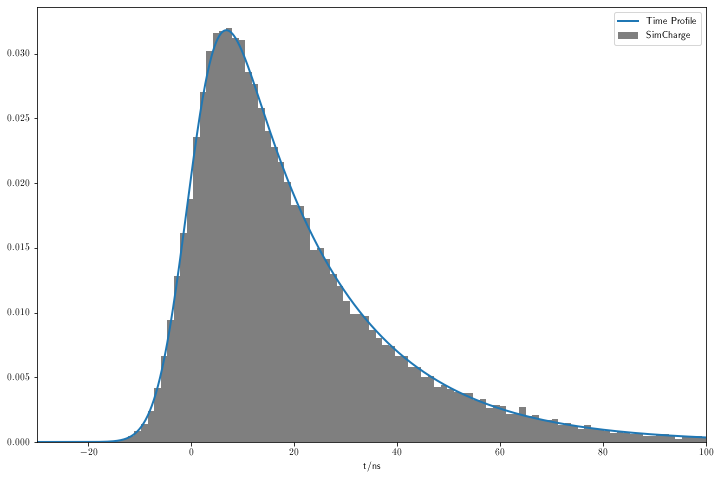

In [7]:
plt.close()
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot()
t = np.arange(-40, 120, 0.1)
ax.plot(t, wff.convolve_exp_norm(t, Tau, Sigma), label='Time Profile')
ax.hist(pelist['HitPosInWindow'] - np.repeat(t0['T0'], np.unique(pelist['TriggerNo'], return_counts=True)[1]), bins=200, alpha=0.5, label='SimCharge', density=True, color=colors['truth'])
ax.set_xlim(-30, 100)
ax.legend()
ax.set_xlabel('t/ns')
plt.show()

# 模拟中的波形分布

100%|██████████| 9982/9982 [00:03<00:00, 3108.03it/s]


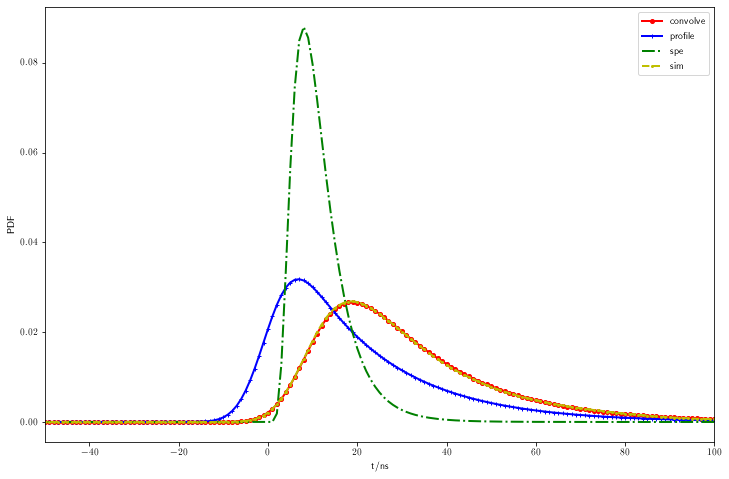

In [8]:
t = np.arange(-100, 929, 1)
s = np.arange(-100, 300, 1)
pan = np.zeros(len(t))
for i in tqdm(range(len(wave))):
    ti = int(np.round(t0[i]['T0']).item())
    w = wave[i]['Waveform']
    w = np.hstack([w[ti - 100:], w[:ti - 100]])
    pan = pan + w
plt.close()
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot()
b = (wff.convolve_exp_norm(s, Tau, Sigma)[:, None] * wff.spe(t - s[:, None], tau=p[0], sigma=p[1], A=p[2])).sum(axis=0)
ax.plot(t, b / b.sum(), 'r-o', label='convolve')
ax.plot(t, wff.convolve_exp_norm(t, Tau, Sigma), 'b-+', label='profile')
ax.plot(t, wff.spe(t, tau=p[0], sigma=p[1], A=p[2]) / 160, 'g-.', label='spe')
ax.plot(t, pan / pan.sum(), 'y--.', label='sim')
ax.set_ylabel('PDF')
ax.set_xlim(-50, 100)
ax.set_xlabel('t/ns')
ax.legend()
plt.savefig('t.png')

# 模拟中的电荷分布

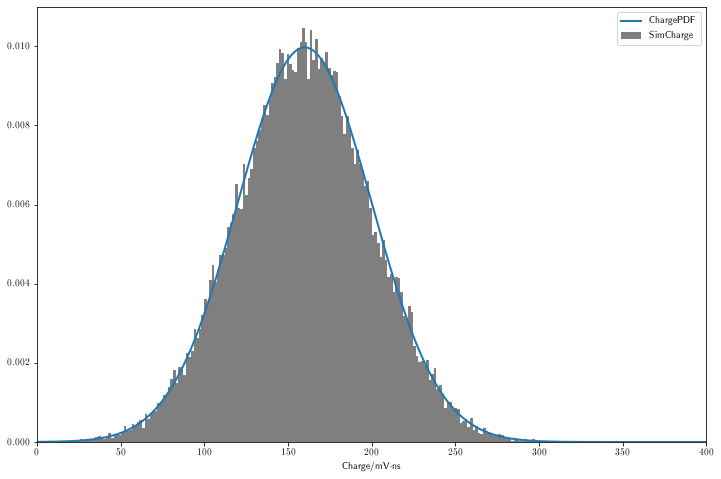

In [9]:
plt.close()
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot()
t = np.arange(0, 1000, 0.1)
ax.plot(t, norm.pdf(t, loc=160., scale=40.) / (1 - norm.cdf(0, loc=160., scale=40.)), label='ChargePDF')
ax.hist(pelist['Charge'], bins=200, alpha=0.5, label='SimCharge', density=True, color=colors['truth'])
ax.set_xlim(0, 400)
ax.legend()
ax.set_xlabel('Charge/mV·ns')
plt.show()

# 重建结果的时间分布

In [8]:
plt.close()
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot()
t = np.arange(-40, 120, 0.1)
ax.plot(t, wff.convolve_exp_norm(t, Tau, Sigma), label='Time Profile', color=colors['truth'])
for m in methods:
    so = h5py.File('result/' + m + '/solu/' + para + '.h5', 'r', libver='latest', swmr=True)
    ch = h5py.File('result/' + m + '/char/' + para + '.h5', 'r', libver='latest', swmr=True)
    solut0 = so['starttime']
    chargepelist = ch['photoelectron']
    ax.hist(chargepelist['HitPosInWindow'] - np.repeat(solut0['tscharge'] if m != 'fbmp' else solut0['tscharge'][:, 0], np.unique(chargepelist['TriggerNo'], return_counts=True)[1]), bins=200, alpha=0.5, label=m, density=True, color=colors[m])
ax.set_xlim(-30, 100)
ax.legend()
ax.set_xlabel('t/ns')
ax.set_ylabel('Normalized Count')
plt.show()

# 重建结果的电荷分布

In [9]:
plt.close()
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot()
t = np.arange(0, 1000, 0.1)
ax.plot(t, norm.pdf(t, loc=160., scale=40.) / (1 - norm.cdf(0, loc=160., scale=40.)), label='$\mathrm{ChargePDF}$', color=colors['truth'])
th = 160 * 5 * 1e-4
for m in methods:
    ch = h5py.File('result/' + m + '/char/' + para + '.h5', 'r', libver='latest', swmr=True)
    cha = ch['photoelectron']['Charge']
    ax.hist(cha[cha > th], bins=np.arange(th, 400, 5), alpha=0.5, label='$'+labels[m]+'$', density=True, color=colors[m])
ax.set_xlim(0, 350)
ax.set_ylim(0, 0.013)
ax.legend()
ax.set_xlabel('$\mathrm{Charge}/\si{mV\cdot ns}$')
ax.set_ylabel('Normalized Count')
plt.savefig('Note/figures/recchargehist.png')
plt.savefig('Note/figures/recchargehist.pdf')
plt.savefig('Note/figures/recchargehist.pgf')
plt.show()

In [16]:
plt.close()
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot()
t = np.arange(0, 1000, 0.1)
ax.plot(t, norm.pdf(t, loc=160., scale=40.) / (1 - norm.cdf(0, loc=160., scale=40.)), label='$\mathrm{ChargePDF}$', color=colors['truth'])
th = 160 * 5 * 1e-4
for m in methods:
    wa = h5py.File('waveform/' + para + '.h5', 'r', libver='latest', swmr=True)
    ch = h5py.File('result/' + m + '/char/' + para + '.h5', 'r', libver='latest', swmr=True)
    so = h5py.File('result/' + m + '/solu/' + para + '.h5', 'r', libver='latest', swmr=True)
    wav = wa['SimTruth/T'][:]
    sol = so['starttime'][:]
    tr = sol['TriggerNo'][np.abs(sol['tscharge'] if m != 'fbmp' else sol['tscharge'][:, 0] - wav['T0']) > 3]
    cha = ch['photoelectron'][:]
    cha = cha[np.isin(cha['TriggerNo'], tr)]
    ax.hist(cha['Charge'][cha['Charge'] > th], bins=np.arange(th, 400, 5), alpha=0.5, label='$'+labels[m]+'$', density=True, color=colors[m])
ax.set_xlim(0, 350)
ax.set_ylim(0, 0.013)
ax.legend()
ax.set_xlabel('$\mathrm{Charge}/\si{mV\cdot ns}$')
ax.set_ylabel('Normalized Count')
plt.savefig('./recchargehist.png')
plt.show()

In [29]:
plt.close()
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot()
wa = h5py.File('waveform/' + para + '.h5', 'r', libver='latest', swmr=True)
ch = h5py.File('result/' + 'fbmp' + '/char/' + para + '.h5', 'r', libver='latest', swmr=True)
so = h5py.File('result/' + 'fbmp' + '/solu/' + para + '.h5', 'r', libver='latest', swmr=True)
wav = wa['SimTruth/T'][:]
sol = so['starttime'][:]
n = 7
thso = h5py.File('result/' + 'threshold' + '/solu/' + para + '.h5', 'r', libver='latest', swmr=True)
thsol = thso['starttime'][:]
ax.scatter(np.abs(sol['tscharge'][:, 0] - wav['T0'])[np.abs(sol['tscharge'][:, 0] - wav['T0']) > n], np.abs(thsol['tscharge'] - wav['T0'])[np.abs(sol['tscharge'][:, 0] - wav['T0']) > n])
ax.grid()
ax.set_xlabel('$\Delta t_{\mathrm{FBMP}}/\si{ns}$')
ax.set_ylabel('$\Delta t_{\mathrm{Shift}}/\si{ns}$')
plt.savefig('./t1.png')
plt.show()

# 单事例分析

In [ ]:
# methods = ['mcmc']
i = 5
pan = np.arange(len(wave[i]['Waveform']))
ind = np.argwhere(wave[i]['Waveform'] > spe_pre[0]['std'] * 5).flatten()
xmin = ((ind.min() - spe_pre[0]['mar_l']) // 50) * 50
xmax = max(((ind.max() + spe_pre[0]['mar_r']) // 50 + 1) * 50, xmin + 150)
plt.close()
fig = plt.figure(figsize=(9, 6))
ax = fig.add_subplot()
truth = pelist[pelist['TriggerNo'] == i]
ax2 = ax.twinx()
ax2.plot(wave[i]['Waveform'], color=colors['truth'])
for m, mi in zip(methods, list(range(len(methods)))):
    ch = h5py.File('result/' + m + '/char/' + para + '.h5', 'r', libver='latest', swmr=True)
    charge = ch['photoelectron'][ch['photoelectron']['TriggerNo'] == i]
    wav_sub = np.sum([np.where(pan > charge['HitPosInWindow'][j], wff.spe(pan - charge['HitPosInWindow'][j], tau=p[0], sigma=p[1], A=p[2]) * charge['Charge'][j], 0) for j in range(len(charge['HitPosInWindow']))], axis=0) / np.sum(spe_pre[0]['spe'])
    ax.vlines(charge['HitPosInWindow'], ymin=0, ymax=charge['Charge'], label=m, color=colors[m], linewidth=3)
    ax2.plot(wav_sub, color=colors[m])
ax.vlines(truth['HitPosInWindow'], ymin=0, ymax=truth['Charge'], label='truth', color=colors['truth'])
ax.set_xlim(xmin, xmax)
lines, xlabels = ax.get_legend_handles_labels()
lines2, xlabels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, xlabels + xlabels2)
align.yaxes(ax, 0, ax2, 0)
ax.set_xlabel('t/ns')
ax.set_ylabel('Charge/mV·ns')
ax2.set_ylabel('Voltage/mV')
plt.savefig('waveformdemo.png')
plt.show()

# 检查各方法的稀疏性

# 探索针对稀疏参数的优化方法

# 检查 MCMC 中 A 的值

# 检查单光电子响应的频域

In [ ]:
with h5py.File('waveform/' + para + '.h5', 'r', libver='latest', swmr=True) as ipt:
    ent = ipt['Readout/Waveform'][:]
    tru = ipt['SimTriggerInfo/PEList'][:]
    gmu = ipt['SimTriggerInfo/PEList'].attrs['gmu']
    gsigma = ipt['SimTriggerInfo/PEList'].attrs['gsigma']
    npe = ipt['SimTruth/T'].attrs['npe']

# 检查初始化

In [ ]:
spe_pre = wff.read_model('spe.h5', wff.nshannon)
chunk = len(ent) // 100 + 1
slices = np.vstack((np.arange(0, len(ent), chunk), np.append(np.arange(chunk, len(ent), chunk), len(ent)))).T.astype(int).tolist()

def test(a0, a1):
    l = a1 - a0
    s = np.zeros(l).astype(int)
    r = np.zeros(l).astype(int)
    w = np.zeros(int(l * 0.1))
    start = 0
    end = 0
    for i in range(a0, a1):
        cid = ent[i]['ChannelID']
        eid = ent[i]['TriggerNo']

        A, wave_r, tlist, t0_init, t0_init_delta, char_init, n = wff.initial_params(ent[i]['Waveform'], spe_pre[cid], Mu, Tau, Sigma, 160., 40., 0.1, 3, spe_pre[0]['parameters'], 4, 3, is_t0=True, is_delta=False, nshannon=wff.nshannon)
        truth = np.sort(tru[(tru['TriggerNo'] == eid) & (tru['PMTId'] == cid)], kind='stable', order=['TriggerNo', 'PMTId', 'HitPosInWindow'])
        truth_time = np.round(truth['HitPosInWindow']).astype(int)
        s[i - a0] = len(truth_time) - np.isin(truth_time, tlist).sum().astype(int)
        r[i - a0] = len(tlist)
        t = truth['Charge'][np.logical_not(np.isin(truth_time, tlist))]
        end = start + len(t)
        w[start:end] = t
        start = end
    w = w[:end]
    return s, r, w

with Pool(100) as pool:
    result = pool.starmap(partial(test), slices)

s = np.hstack([result[i][0] for i in range(len(slices))])
r = np.hstack([result[i][1] for i in range(len(slices))])
w = np.hstack([result[i][2] for i in range(len(slices))])
    
plt.close()
fig = plt.figure(figsize=(18, 6))
ax = fig.add_subplot(131)
b, c = np.unique(s, return_counts=True)
ax.bar(b, c, alpha=0.6)
ax.set_yscale('log')
ax.set_ylim(0.9, 1e4)
ax = fig.add_subplot(132)
# b, c = np.unique(r, return_counts=True)
# ax.bar(b, c, alpha=0.6)
ax.hist(r, bins=100, alpha=0.6)
ax = fig.add_subplot(133)
# b, c = np.unique(r, return_counts=True)
# ax.bar(b, c, alpha=0.6)
ax.hist(tru['Charge'][tru['Charge'] < 60], bins=20, alpha=0.6, label='all')
ax.hist(w, bins=20, alpha=0.6, label='untest')
ax.legend(loc='upper left')
plt.savefig('t.png')
plt.show()